In [1]:
from deap import algorithms,base,creator, tools, gp
import numpy as np
import operator as op
import random
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt

In [2]:
data = np.array(
   [  #-INPUT-##-------OUTPUT------#
      [0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
      [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
      [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
      [0, 1, 1, 1, 1, 1, 1, 0, 0, 1],
      [1, 0, 0, 0, 1, 1, 0, 0, 1, 1],
      [1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
      [1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
   ]
).astype(np.bool_)

# inputs = list(map(tuple,data[:,:3].tolist()))
# outputs = list(map(tuple,(data[:,3:].tolist())))
inputs = data[:,:3]
outputs = data[:,3:]

In [3]:
pset = gp.PrimitiveSet("main",3,"IN")
pset.addPrimitive(np.logical_and,2,name="vand")
pset.addPrimitive(np.logical_or,2,name="vor")
pset.addPrimitive(np.logical_not,1,name="vnot")
pset.addTerminal(True,name="1")
pset.addTerminal(False, name="0")

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def eval(individual,*,i):
   func = toolbox.compile(expr=individual)
   results = func(*inputs.T) == outputs[:,i]
   return (results.sum(),)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("select",tools.selTournament,tournsize=3)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [7]:
random.seed(21)
bests = []
for i in range(7):
   pop = toolbox.population(n=300)
   hof = tools.HallOfFame(1)
   stats=None
   if hasattr(toolbox,"evaluate"):
      toolbox.unregister("evaluate")
   toolbox.register("evaluate",eval,i=i)

   pop, logbook = algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 40, stats, halloffame=hof,verbose=False)
   bests.append(hof[0])

In [24]:
ref_colors = {
   "vor": "royalblue",
   "vand": "mediumvioletred",
   "vnot": "darkolivegreen",
   "IN0": "dimgray",
   "IN1": "dimgray",
   "IN2": "dimgray",
   "0": "black",
   False: "black",
   "1": "lavender",
   True: "lavender"
}
def graph(result):
   nodes, edges, labels = gp.graph(result)
   g = nx.Graph()
   g.add_nodes_from(nodes)
   g.add_edges_from(edges)
   pos = nx.nx_agraph.graphviz_layout(g, prog="dot")

   node_colors = [ref_colors[labels[n]] for n in nodes]
   nx.draw_networkx_nodes(g, pos, node_size=1000, node_shape="H", node_color=node_colors)
   nx.draw_networkx_edges(g, pos)
   nx.draw_networkx_labels(g, pos, labels, font_color='white')
   plt.show()

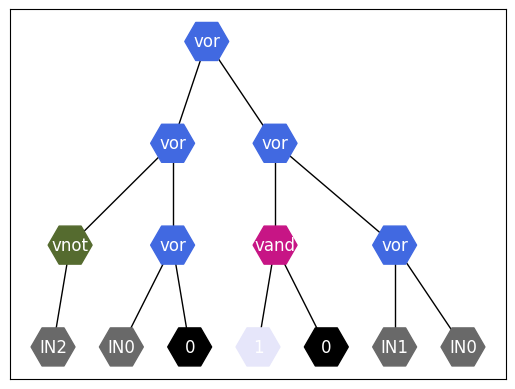

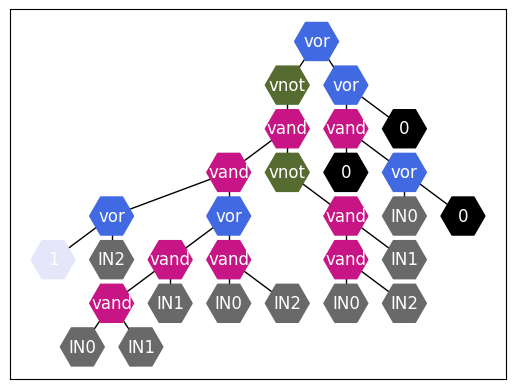

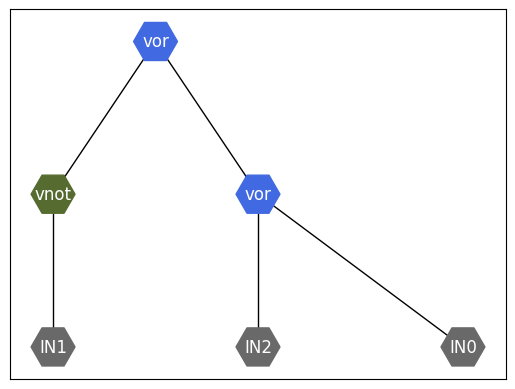

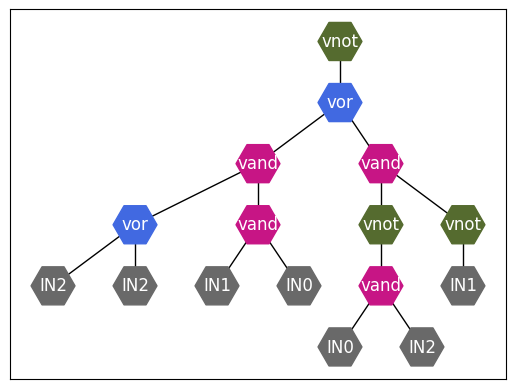

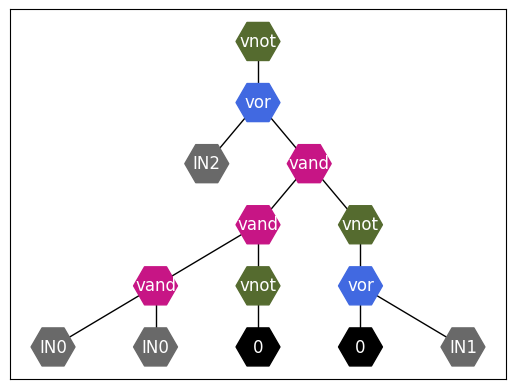

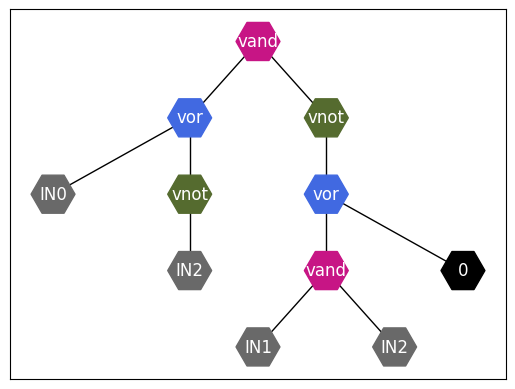

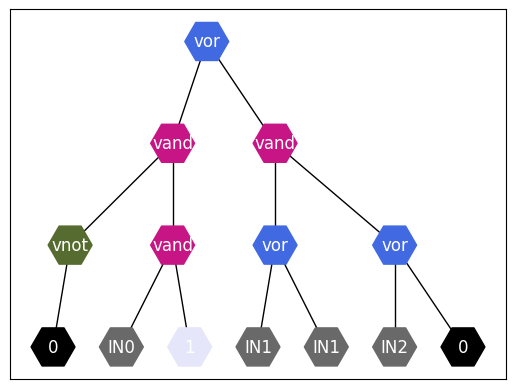

In [25]:
for r in bests:
   graph(r)
